In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *
import sys
from patsy import dmatrices

In [2]:
path = Path(os.getcwd())

In [3]:
base_dir = path.parent.parent

In [4]:
data_in = os.path.join(str(base_dir) , "da_data_repo/share-health/clean/")
data_out = os.path.join(str(base_dir), "da_case_studies/ch11-smoking-health-risk/")
output = os.path.join(str(base_dir), "da_case_studies/ch12-stock-returns-risk/output/")
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")

In [5]:
share = pd.read_csv(os.path.join(data_in,"share-health.csv"))

In [6]:
sys.path.append(func)

In [7]:
from py_helper_functions import *

In [ ]:
#Part I

In [8]:
share.head()

,mergeid,wave,country,country_mod,int_year,int_month,female,age,eduyears_mod,sphus,br015,smoking,ever_smoked,income_pct_w4,bmi,mar_stat
0,AT-000327-01,1,11,40,2004,6,0,51.900002,-15.0,1,2,5,5,-13,32.787994,1
1,AT-000327-01,2,11,40,2007,3,0,54.700001,-3.0,5,4,5,5,-13,20.281233,1
2,AT-000327-02,1,11,40,2004,6,1,48.900002,3.0,1,3,5,5,-13,31.161373,1
3,AT-000327-02,2,11,40,2007,3,1,51.700001,3.0,2,1,5,5,-13,30.461119,1
4,AT-000674-01,4,11,40,2011,11,1,59.700001,3.0,3,1,5,5,1,24.023809,6


In [9]:
share['healthy']=0
share.loc[(share['sphus']==1) | (share['sphus']==2),'healthy']=1
share.loc[~((share['sphus']>0) & (share['sphus']<=5)),'healthy']=np.nan

In [10]:
share['healthy'].value_counts()

0.0    213847
1.0     73808
Name: healthy, dtype: int64

In [11]:
share = share.dropna(how='any')

In [12]:
share['baseline'] = 0
share.loc[share['wave']==4,'baseline']=1
share['endline'] = 0
share.loc[share['wave']==6,'endline']=1

In [13]:
share['baseline'].value_counts()

0    229773
1     57882
Name: baseline, dtype: int64

In [14]:
share['endline'].value_counts()

0    219568
1     68087
Name: endline, dtype: int64

In [15]:
#Part 2

In [16]:
share = pd.read_csv('ch11_share.csv')

In [17]:
share.head()

,mergeid,wave,country,country_mod,int_year,int_month,female,age,sphus,br015,...,income10,bmi,mar_stat,healthy,baseline,endline,stayshealthy,exerc,married,eduyears
0,AT-001492-02,4,11,40,2011,9,0,59.799999,2,3,...,8,23.198315,1,1,1,0,1,0,1,13.0
1,AT-002136-03,4,11,40,2011,8,1,58.200001,1,2,...,9,24.801588,1,1,1,0,1,0,1,14.0
2,AT-002800-01,4,11,40,2011,9,1,57.000000,2,4,...,3,22.038567,3,1,1,0,1,0,0,23.0
3,AT-009262-02,4,11,40,2011,12,0,59.299999,2,1,...,6,25.826447,1,1,1,0,0,1,1,12.0
4,AT-009376-01,4,11,40,2011,9,0,53.299999,2,1,...,8,26.827421,1,1,1,0,0,1,1,3.0


In [18]:
lpm1 = smf.ols('stayshealthy ~ smoking', data=share).fit()

In [19]:
print(lpm1.summary())

                            OLS Regression Results                            
Dep. Variable:           stayshealthy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     11.14
Date:                Wed, 19 Aug 2020   Prob (F-statistic):           0.000856
Time:                        16:00:58   Log-Likelihood:                -2181.2
No. Observations:                3109   AIC:                             4366.
Df Residuals:                    3107   BIC:                             4379.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6204      0.010     62.423      0.0

In [20]:
print(lpm1.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:           stayshealthy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     10.84
Date:                Wed, 19 Aug 2020   Prob (F-statistic):            0.00101
Time:                        16:00:58   Log-Likelihood:                -2181.2
No. Observations:                3109   AIC:                             4366.
Df Residuals:                    3107   BIC:                             4379.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6204      0.010     62.777      0.0

In [21]:
share['pred1']=lpm1.predict()

In [22]:
pd.crosstab(index = share['pred1'],columns= share['smoking'])

smoking,0,1
pred1,,
0.550287,0,696
0.620390,2413,0


In [23]:
pd.crosstab(index = share['stayshealthy'],columns= share['smoking'])

smoking,0,1
stayshealthy,,
0,916,313
1,1497,383


In [24]:
share['weight']=share.groupby(['smoking','stayshealthy'])['smoking'].transform(len)

In [25]:
share['weight_2']=share['weight']/1000

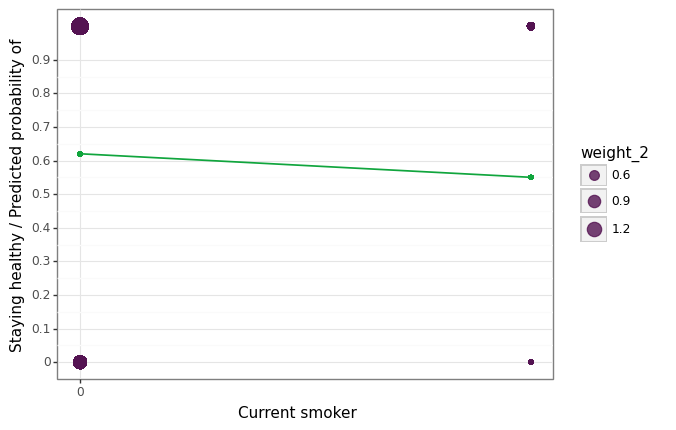

<ggplot: (-9223372036552404904)>

In [26]:
g1 = (ggplot(data = share) 
 + geom_point(aes(x = 'smoking', y = 'pred1'), size = 1, color=color[1]) 
 + geom_line(aes(x = 'smoking', y = 'pred1'), colour=color[1],  size=0.7) 
 + geom_point(aes(x = 'smoking', y = 'stayshealthy', size='weight_2'), fill = color[2], color=color[2], alpha=0.8)
 + labs(x = "Current smoker",y = "Staying healthy / Predicted probability of ")
 +  coord_cartesian(xlim = [0, 1], ylim=[0,1]) 
 + scale_y_continuous(limits = [0,1], breaks = seq(0,1,0.1))
 + scale_x_continuous(limits = [0,1], breaks = seq(0,1,1))
 + theme_bw() 
)
g1

In [27]:
lpm2 = smf.ols('stayshealthy ~ smoking + ever_smoked', data=share).fit()

In [28]:
print(lpm2.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:           stayshealthy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.665
Date:                Wed, 19 Aug 2020   Prob (F-statistic):            0.00350
Time:                        16:00:59   Log-Likelihood:                -2181.0
No. Observations:                3109   AIC:                             4368.
Df Residuals:                    3106   BIC:                             4386.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6154      0.012     50.204      

In [29]:
share['weight']=share.groupby(['eduyears','stayshealthy'])['smoking'].transform(len)/100

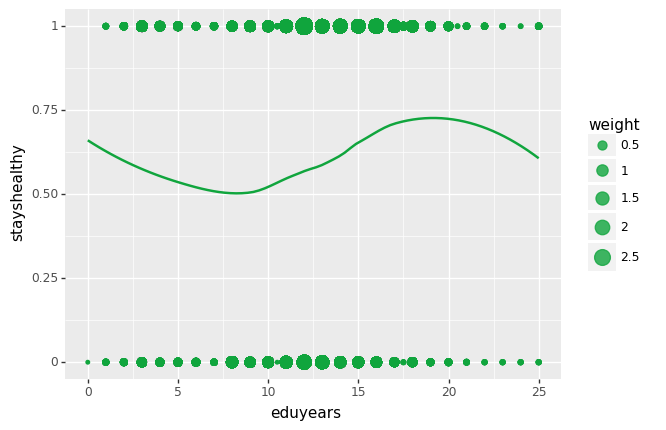

<ggplot: (-9223372036549166094)>

In [30]:
g2 = (ggplot(data = share) 
 + geom_point(aes(x = 'eduyears', y = 'stayshealthy',size='weight'), color=color[1],alpha=0.8) 
 + geom_smooth(aes(x = 'eduyears', y = 'stayshealthy'),method="loess",se=False, color=color[1]) 
# + labs(x = "Years of education",y = "Probability of staying healthy ")
# + coord_cartesian(xlim = [0, 1], ylim=[0,1]) 
# + scale_x_continuous(expand = [0.01,0.01], limits = [0,25], breaks = seq(0,25,4))
# + scale_y_continuous(expand = [0.01,0.01], limits = [0,1], breaks = seq(0,1,0.1))
# + theme_bw() 
)
g2

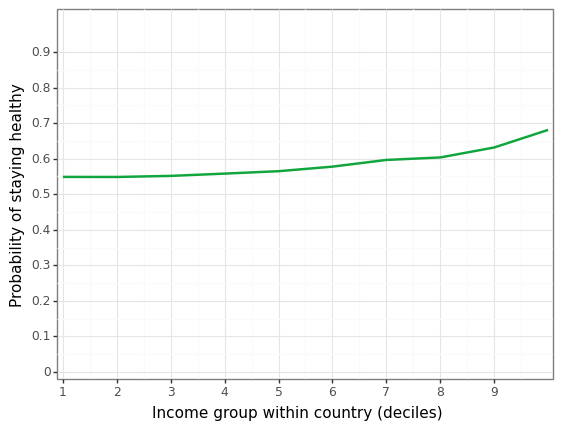

<ggplot: (-9223372036546203858)>

In [31]:
g2b = (ggplot(data = share)
  + geom_smooth(aes(x='income10',y='stayshealthy'),method="loess",se=False, color=color[1]) 
  + scale_x_continuous(expand = [0.01,0.01], limits = [1,10], breaks = seq(1,10,1))
  + scale_y_continuous(expand = [0.01,0.01], limits = [0,1], breaks = seq(0,1,0.1)) 
  + labs(x = "Income group within country (deciles)",y = "Probability of staying healthy ") 
  + theme_bw()
  )
g2b

In [32]:
#Part 3

In [33]:
#lpm3 <-lm(stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears, c(8,18)) + 
#            income10 + lspline(bmi, c(35)) + exerc + as.factor(country), data=share)

In [34]:
share['country'] = share['country'].astype('category')

In [35]:
y,X = dmatrices("stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                 income10 + lspline(bmi,[35]) + exerc + country",share)

In [36]:
lpm3 = sm.OLS(y, X)
lpm3 = lpm3.fit()

In [37]:
print(lpm3.get_robustcov_results(cov_type='HC1').summary())

                            OLS Regression Results                            
Dep. Variable:           stayshealthy   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     17.32
Date:                Wed, 19 Aug 2020   Prob (F-statistic):           4.57e-68
Time:                        16:01:01   Log-Likelihood:                -2018.4
No. Observations:                3109   AIC:                             4087.
Df Residuals:                    3084   BIC:                             4238.
Df Model:                          24                                         
Covariance Type:                  HC1                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [38]:
share['pred_lpm'] = lpm3.predict()

In [39]:
share['pred_lpm'].describe()

count    3109.000000
mean        0.604696
std         0.156665
min         0.036103
25%         0.500122
50%         0.607342
75%         0.713423
max         1.011026
Name: pred_lpm, dtype: float64

In [40]:
#Part 4

In [41]:
logit = sm.GLM(y,X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))

In [42]:
type(logit)

statsmodels.genmod.generalized_linear_model.GLM

In [43]:
logit = sm.GLM(y,X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
logit = logit.fit()

In [44]:
type(logit)

statsmodels.genmod.generalized_linear_model.GLMResultsWrapper

In [45]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                            GLM   Df Residuals:                     3084
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1918.8
Date:                Wed, 19 Aug 2020   Deviance:                       3837.5
Time:                        16:01:02   Pearson chi2:                 3.12e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [46]:
share['pred_logit'] = logit.predict()

In [47]:
logit = sm.Logit(y,X)

In [48]:
type(logit)

statsmodels.discrete.discrete_model.Logit

In [49]:
logit_result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.617166
         Iterations 5


In [50]:
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                          Logit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Wed, 19 Aug 2020   Pseudo R-squ.:                 0.08031
Time:                        16:01:02   Log-Likelihood:                -1918.8
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.329e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [51]:
logit_margef_results = logit_result.get_margeff()

In [52]:
logit_margef_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           stayshealthy
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
country[T.12]                    -0.2106      0.070     -2.993      0.003      -0.349      -0.073
country[T.13]                    -0.0423      0.059     -0.714      0.475      -0.158       0.074
country[T.15]                    -0.1406      0.041     -3.406      0.001      -0.221      -0.060
country[T.16]                    -0.2399      0.039     -6.191      0.000      -0.316      -0.164
country[T.17]                    -0.1682      0.036     -4.701      0.000      -0.238      -0.098
country[T.18]                     0.0934      0.039      2.417      0.016       0.018       0.169
country[T.20]                     0.0146      0.034      0.427      0.670      -0.052       0.081
country[T.23]                    -0.1229      0.033     -3.678      0.000      -0.188      -0.057
country[T.28]                    -0.1618      0.037     -4.345      0.000      -0.235      -0.089
country[T.29]                    -0.3152      0.084     -3.751      0.000      -0.480      -0.150
country[T.33]                    -0.3382      0.063     -5.332      0.000      -0.463      -0.214
country[T.34]                    -0.1972      0.043     -4.538      0.000      -0.282      -0.112
country[T.35]                    -0.2901      0.044     -6.582      0.000      -0.376      -0.204
smoking                          -0.0609      0.023     -2.611      0.009      -0.107      -0.015
ever_smoked                       0.0168      0.020      0.849      0.396      -0.022       0.055
female                            0.0345      0.018      1.968      0.049       0.000       0.069
age                              -0.0026      0.003     -0.859      0.390      -0.009       0.003
lspline(eduyears, [8, 18])[0]    -0.0006      0.007     -0.090      0.928      -0.015       0.013
lspline(eduyears, [8, 18])[1]     0.0170      0.003      5.097      0.000       0.010       0.023
lspline(eduyears, [8, 18])[2]    -0.0098      0.012     -0.825      0.409      -0.033       0.013
income10                          0.0076      0.003      2.461      0.014       0.002       0.014
lspline(bmi, [35])[0]            -0.0123      0.002     -5.109      0.000      -0.017      -0.008
lspline(bmi, [35])[1]             0.0067      0.015      0.439      0.661      -0.023       0.036
exerc                             0.0546      0.017      3.248      0.001       0.022       0.088
=================================================================================================
"""

In [53]:
probit = sm.Probit(y,X)

In [54]:
probit_result = probit.fit()

Optimization terminated successfully.
         Current function value: 0.617255
         Iterations 5


In [55]:
probit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                         Probit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Wed, 19 Aug 2020   Pseudo R-squ.:                 0.08018
Time:                        16:01:02   Log-Likelihood:                -1919.0
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.722e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.4340      0.540      2.656      0.008       0.376       2.492
country[T.12]                    -0.5952      0.203     -2.926      0.003      -0.994      -0.197
country[T.13]                    -0.1128      0.166     -0.678      0.498      -0.439       0.213
country[T.15]                    -0.4007      0.119     -3.368      0.001      -0.634      -0.167
country[T.16]                    -0.6872      0.113     -6.082      0.000      -0.909      -0.466
country[T.17]                    -0.4761      0.103     -4.615      0.000      -0.678      -0.274
country[T.18]                     0.2573      0.105      2.440      0.015       0.051       0.464
country[T.20]                     0.0425      0.096      0.445      0.657      -0.145       0.230
country[T.23]                    -0.3450      0.095     -3.622      0.000      -0.532      -0.158
country[T.28]                    -0.4579      0.108     -4.252      0.000      -0.669      -0.247
country[T.29]                    -0.8784      0.235     -3.740      0.000      -1.339      -0.418
country[T.33]                    -0.9741      0.182     -5.359      0.000      -1.330      -0.618
country[T.34]                    -0.5592      0.126     -4.426      0.000      -0.807      -0.312
country[T.35]                    -0.8280      0.129     -6.407      0.000      -1.081      -0.575
smoking                          -0.1705      0.066     -2.568      0.010      -0.301      -0.040
ever_smoked                       0.0443      0.056      0.793      0.428      -0.065       0.154
female                            0.0973      0.050      1.953      0.051      -0.000       0.195
age                              -0.0083      0.009     -0.955      0.339      -0.025       0.009
lspline(eduyears, [8, 18])[0]    -0.0021      0.020     -0.102      0.918      -0.041       0.037
lspline(eduyears, [8, 18])[1]     0.0478      0.010      5.015      0.000       0.029       0.066
lspline(eduyears, [8, 18])[2]    -0.0286      0.033     -0.864      0.388      -0.093       0.036
income10                          0.0216      0.009      2.446      0.014       0.004       0.039
lspline(bmi, [35])[0]            -0.0346      0.007     -5.002      0.000      -0.048      -0.021
lspline(bmi, [35])[1]             0.0169      0.044      0.388      0.698      -0.069       0.102
exerc                             0.1510      0.048      3.148      0.002       0.057       0.245
=================================================================================================
"""

In [56]:
share['pred_probit']=probit_result.predict()

In [57]:
share['pred_probit'].describe()

count    3109.000000
mean        0.604763
std         0.156611
min         0.103114
25%         0.498824
50%         0.612903
75%         0.720459
max         0.930006
Name: pred_probit, dtype: float64

In [58]:
probit_margef_results = probit_result.get_margeff()

In [59]:
probit_margef_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:           stayshealthy
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
country[T.12]                    -0.2096      0.071     -2.938      0.003      -0.349      -0.070
country[T.13]                    -0.0397      0.059     -0.678      0.498      -0.155       0.075
country[T.15]                    -0.1411      0.042     -3.386      0.001      -0.223      -0.059
country[T.16]                    -0.2420      0.039     -6.193      0.000      -0.319      -0.165
country[T.17]                    -0.1677      0.036     -4.662      0.000      -0.238      -0.097
country[T.18]                     0.0906      0.037      2.446      0.014       0.018       0.163
country[T.20]                     0.0150      0.034      0.445      0.656      -0.051       0.081
country[T.23]                    -0.1215      0.033     -3.643      0.000      -0.187      -0.056
country[T.28]                    -0.1613      0.038     -4.288      0.000      -0.235      -0.088
country[T.29]                    -0.3094      0.082     -3.764      0.000      -0.470      -0.148
country[T.33]                    -0.3430      0.063     -5.435      0.000      -0.467      -0.219
country[T.34]                    -0.1969      0.044     -4.468      0.000      -0.283      -0.111
country[T.35]                    -0.2916      0.045     -6.536      0.000      -0.379      -0.204
smoking                          -0.0601      0.023     -2.575      0.010      -0.106      -0.014
ever_smoked                       0.0156      0.020      0.793      0.428      -0.023       0.054
female                            0.0343      0.018      1.957      0.050   -5.49e-05       0.069
age                              -0.0029      0.003     -0.956      0.339      -0.009       0.003
lspline(eduyears, [8, 18])[0]    -0.0007      0.007     -0.102      0.918      -0.015       0.013
lspline(eduyears, [8, 18])[1]     0.0168      0.003      5.074      0.000       0.010       0.023
lspline(eduyears, [8, 18])[2]    -0.0101      0.012     -0.864      0.387      -0.033       0.013
income10                          0.0076      0.003      2.453      0.014       0.002       0.014
lspline(bmi, [35])[0]            -0.0122      0.002     -5.060      0.000      -0.017      -0.007
lspline(bmi, [35])[1]             0.0060      0.015      0.388      0.698      -0.024       0.036
exerc                             0.0532      0.017      3.161      0.002       0.020       0.086
=================================================================================================
"""

In [60]:
df_plot = pd.melt(share[['pred_lpm','pred_logit','pred_probit']].rename(
        columns={'pred_logit':'Logit','pred_probit':'Probit'}),
        value_vars=['Logit','Probit'],id_vars=['pred_lpm'])

In [61]:
df_plot

,pred_lpm,variable,value
0,0.654021,Logit,0.659110
1,0.696147,Logit,0.703133
2,0.749901,Logit,0.753263
3,0.703965,Logit,0.711565
4,0.598621,Logit,0.599850
...,...,...,...
6213,0.524138,Probit,0.526791
6214,0.622032,Probit,0.636042
6215,0.517906,Probit,0.523045
6216,0.508623,Probit,0.508890


/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


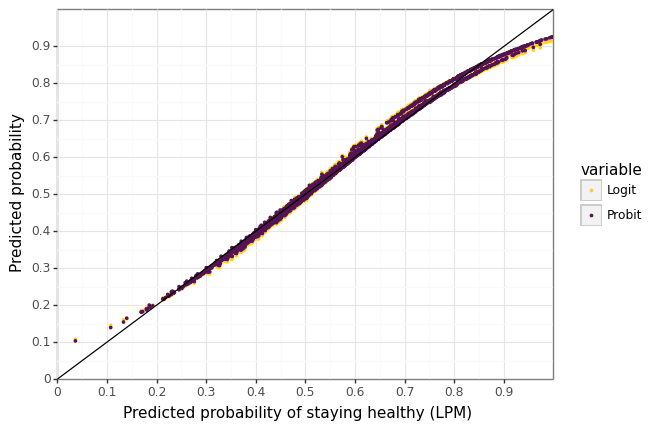

<ggplot: (307689157)>

In [62]:
g5 = (ggplot(data = df_plot) 
  + geom_point(aes(x='pred_lpm', y='value',color='variable'), size=0.5)
  + geom_abline(intercept = 0, slope = 1)    
  #+ geom_line(aes(x='pred_lpm',y='pred_lpm'),    color=color[1], size=0.4)    
  + labs(x = "Predicted probability of staying healthy (LPM)", y="Predicted probability")
  + scale_y_continuous(expand = [0.00,0.0], limits = [0,1], breaks = seq(0,1,0.1)) 
  + scale_x_continuous(expand = [0.00,0.0], limits = [0,1], breaks = seq(0,1,0.1))
  + scale_color_manual(name = "", values=[color[3],color[2], color[1]])     
  + theme_bw()    
  #+ theme_bw()
  #+ theme_bg()+
)
g5

In [63]:
#Part 5 goodness of fit

In [64]:
lpmbase = smf.ols('stayshealthy ~ smoking', data=share).fit()

In [65]:
share['lpmbase']=lpmbase.predict()

/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


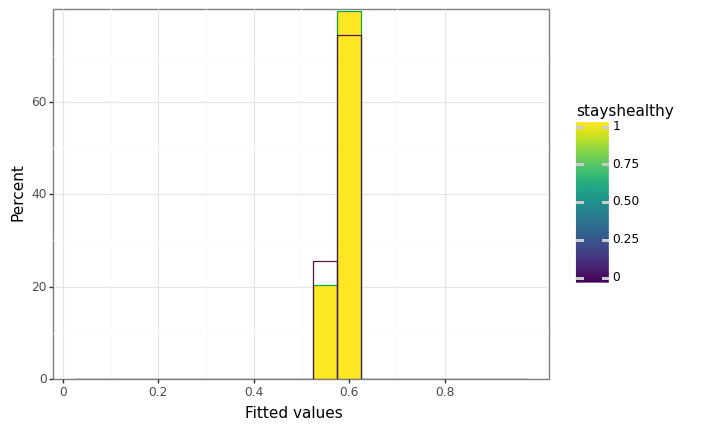

<ggplot: (309616967)>

In [78]:
(ggplot(data = share) 
 + geom_histogram(share[share['stayshealthy']==1],aes(x='lpmbase',fill = 'stayshealthy',y = 'stat(count/sum(count)))*100'),binwidth = 0.05, alpha=1, color=color[1])
 + geom_histogram(share[share['stayshealthy']==0],aes(x='lpmbase',fill = 'stayshealthy',y = 'stat(count/sum(count)))*100'),binwidth = 0.05, alpha=0, color=color[2])
 + ylab("Percent") 
 + xlab("Fitted values") 
 + scale_x_continuous(expand=[0.01,0.01] ,limits = [0,1], breaks = seq(0,1,0.2)) 
 + scale_y_continuous(expand=[0.00,0.00] ,limits = [0,80], breaks = seq(0,80,20)) 
 + theme_bw() 
)